In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [2]:
# Define base distribution

normal = tfd.Normal(loc=0., scale=1.)

In [3]:
# Sample from base distribution

n = 10000
z = normal.sample(n)

### Scale and shift bijector

In [4]:
# Define scale and shift

scale = 4.5
shift = 7

In [5]:
# Define chain bijector

scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [6]:
# We can also use call methods

scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)
scale_and_shift = shift_transf(scale_transf)

In [7]:
# Apply the forward transformation

x = scale_and_shift.forward(z)

In [8]:
# Check the forward transformation

tf.norm(x - (scale*z + shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Plots

<function matplotlib.pyplot.show(close=None, block=None)>

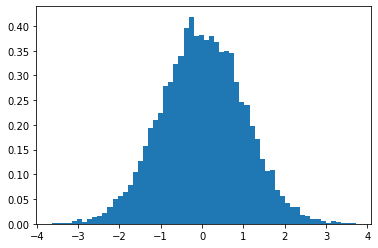

In [9]:
# Plot z density

plt.hist(z, bins=60, density=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

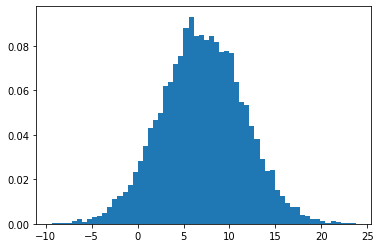

In [10]:
# Plot x density

plt.hist(x, bins=60, density=True)
plt.show

#### Inverse transformation

In [11]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)

In [12]:
# Check inverse transformation

tf.norm(inv_x-z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Log probability

In [13]:
# Compute log prob for x
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
print(log_prob_x)


tf.Tensor([-3.500026  -3.6504679 -2.755453  ... -3.1031961 -2.7630124 -2.6013315], shape=(10000,), dtype=float32)


In [14]:
# We can also use the inverse transformation

log_prob_x = (normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0))
print(log_prob_x)

tf.Tensor([-3.500026  -3.6504679 -2.755453  ... -3.1031961 -2.7630124 -2.6013315], shape=(10000,), dtype=float32)


### Broadcasting

In [15]:
x = tf.random.normal(shape=(100, 1))

In [16]:
# Softfloor bijector

softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [17]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.2, 1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [18]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.])

In [19]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

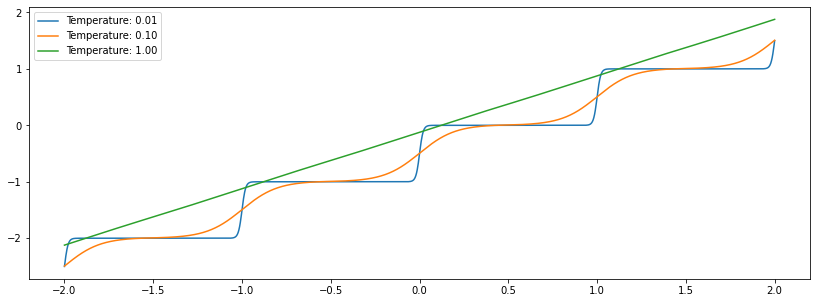

In [20]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(3, softfloor, ['temperature'], x)

In [21]:
# Gumbel bijector using broadcasting

exps = tfb.GumbelCDF(loc=[0.5,1,1.5,2,3],scale=[1,2,2,3,4])

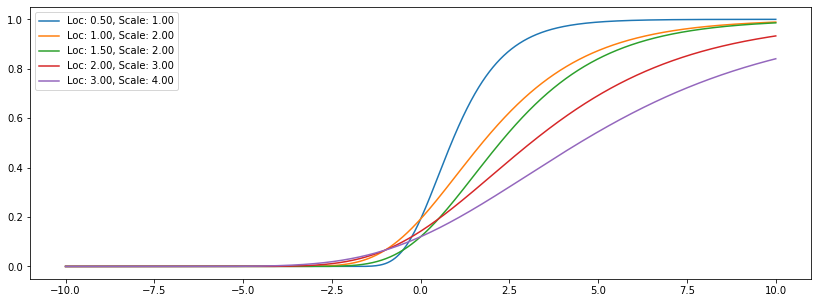

In [22]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5, exps, ['loc','scale'],x)

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [23]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [24]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [25]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [26]:
# Exponential bijector


exp  =tfb.Exp()

In [27]:
# Log normal transformed distribution using exp and normal bijectors

log_normal_td = exp(normal)

In [28]:
# Display event and batch shape

print('batch shape: ', log_normal_td .batch_shape)
print('event shape: ', log_normal_td .event_shape)

batch shape:  ()
event shape:  ()


In [29]:
# Base distribution

z = normal.sample(n)

#### Plots

<function matplotlib.pyplot.show(close=None, block=None)>

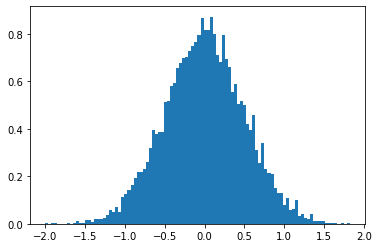

In [30]:
# Plot z density

plt.hist(z, bins=100, density=True)
plt.show

In [31]:
# Transformed distribution

x = log_normal_td.sample(n)

<function matplotlib.pyplot.show(close=None, block=None)>

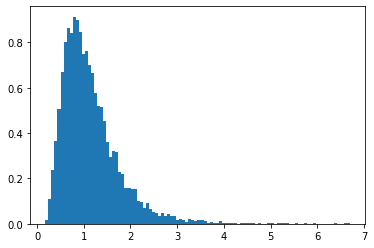

In [32]:
# Plot x density

plt.hist(x, bins=100, density=True)
plt.show

In [33]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)

In [34]:
# Sample log_normal

l = log_normal.sample(n)

<function matplotlib.pyplot.show(close=None, block=None)>

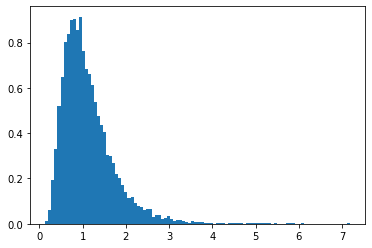

In [35]:
# Plot l density

plt.hist(l, bins=100, density=True)
plt.show

#### Log probability

In [36]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [37]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [38]:
# Check log probs

tf.norm(log_prob - log_prob_td)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Event shape and batch shape

In [39]:
# Set a scaling lower triangular matrix

tril = tf.random.normal((2,4,4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril)

In [40]:
# View of scale_low_tri

scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[-0.4735371 ,  0.        ,  0.        ,  0.        ],
        [ 0.27291396, -0.19812635,  0.        ,  0.        ],
        [ 0.33184195, -1.0093279 , -0.26416942,  0.        ],
        [-1.448463  , -0.01865838,  0.08690156, -1.2569395 ]],

       [[ 0.18404295,  0.        ,  0.        ,  0.        ],
        [-0.82172436,  0.18981498,  0.        ,  0.        ],
        [ 0.22118253, -0.7932171 ,  0.04243834,  0.        ],
        [-0.05981743, -1.4985616 , -0.81434363, -2.1714568 ]]],
      dtype=float32)>

In [41]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [50]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(normal, scale_lin_op, batch_shape=2, event_shape=4)
print(mvn)

TypeError: got an unexpected keyword argument 'batch_shape'

In [48]:
# Display event and batch shape

print('batch shape: ', mvn.batch_shape)
print('event shape: ', mvn.event_shape)

batch shape:  (2,)
event shape:  ()


In [49]:
# Sample

y1 = mvn.sample(sample_shape=(n,))
print(y1.shape)

ValueError: Dimensions 4 and 2 are not compatible

In [ ]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale-scale_low_tri)
print(mvn2)

In [ ]:
# Display event and batch shape

print('batch shape: ', mvn2.batch_shape)
print('event shape: ', mvn2.event_shape)

In [ ]:
# Sample

y2 = mvn2.sample(sample_shape=(n,))
print(y2.shape)

In [ ]:
# Check

xn = normal.sample((n,2,4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn))/ tf.norm(mvn.log_prob(xn))

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [3]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return(tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

        

In [4]:
# Cubic bijector

cubic = Cubic([1.0, -2.0], [1.0, 0.4], validate_args=True)

In [13]:
# Apply forward transformation

x = tf.constant([[1,2], [3,4]])
y = cubic.forward(x)
print(y)

tf.Tensor(
[[   8.        -46.655994]
 [  64.       -438.97598 ]], shape=(2, 2), dtype=float32)


In [6]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

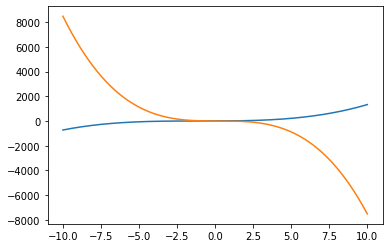

In [7]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))

In [8]:
# Display shape

print(cubic.forward(x).shape)

(500, 2)


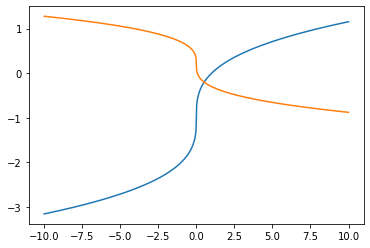

In [9]:
# Plot the inverse

plt.plot(x, cubic.inverse(x))

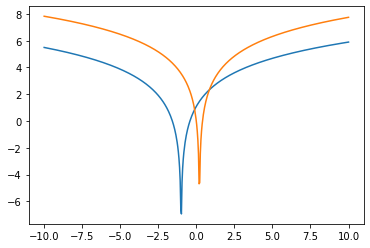

In [10]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x,event_ndims=0))

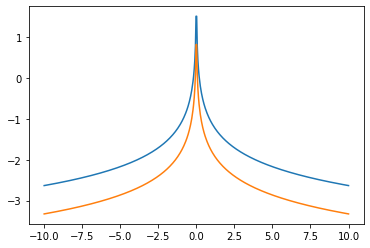

In [11]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x,event_ndims=0))

#### TransformedDistribution and plots

In [14]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=0., scale=1)
cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])

TypeError: got an unexpected keyword argument 'event_shape'

In [15]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

NameError: name 'cubed_normal' is not defined

In [ ]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

In [ ]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [16]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal, event_shape=[2])

TypeError: got an unexpected keyword argument 'event_shape'

In [ ]:
# Samble inv_cubed_normal

n = 1000
g = inv_cubed_normal.sample(n)
g.shape

In [ ]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [ ]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [17]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(cat = tfd.Categorical(probs=probs), components=[tfd.Normal(loc=2.3, scale=0.4), tfd.Normal(loc=-0.8, scale=0.4)])

In [18]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


<function matplotlib.pyplot.show(close=None, block=None)>

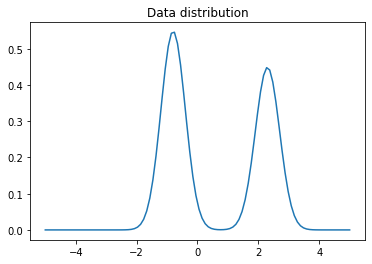

In [20]:
# Plot the data distribution

x = np.linspace(-5.0, 5.0, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data distribution')
plt.show

In [22]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [23]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

<function matplotlib.pyplot.show(close=None, block=None)>

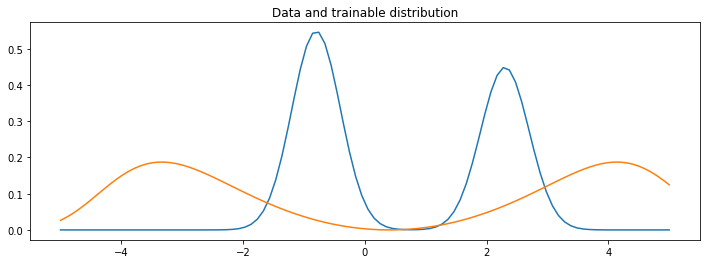

In [24]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.title('Data and trainable distribution')
plt.show

In [25]:
# Train the bijector

num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


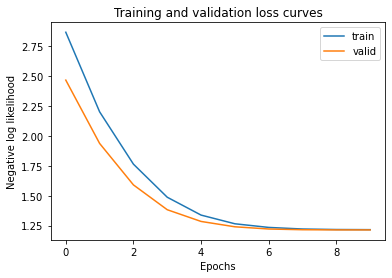

In [26]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

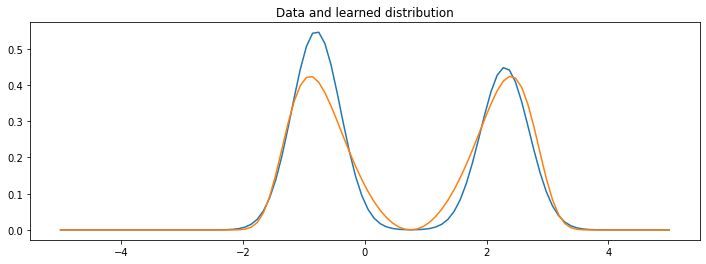

In [27]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='learned')
plt.title('Data and learned distribution')
plt.show

In [28]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5663646>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.425058>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [29]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

C:\Users\mgy0003\AppData\Local\Temp\ipykernel_25440\835795586.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_label = y.astype(np.bool)


(-2.0, 2.0)

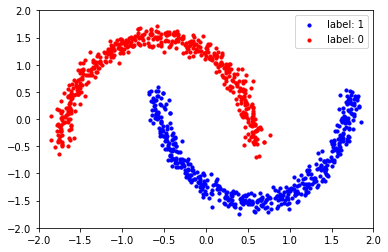

In [30]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [31]:
# Define base distribution

base_distribution = tfd.Normal(loc=0, scale=1)

In [33]:
# Define the trainable distribution

def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow(), event_shape=[2])

TypeError: got an unexpected keyword argument 'event_shape'

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [35]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

In [36]:
# Plot contour

activation = 'relu'
maf = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow(activation=activation), event_shape=[2])

TypeError: got an unexpected keyword argument 'event_shape'

In [37]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [38]:
# Make samples

x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

NameError: name 'trainable_distribution' is not defined

In [39]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

In [40]:
# Plot

_plot(samples)

NameError: name 'samples' is not defined

#### Training a MaskedAutoregressiveFlow bijector

In [41]:
from tensorflow.keras.callbacks import LambdaCallback

In [42]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [43]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)

NameError: name 'trainable_distribution' is not defined

In [44]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

NameError: name 'history' is not defined

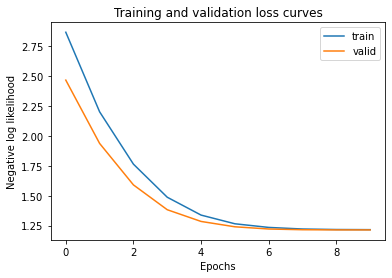

In [45]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples

x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

In [ ]:
# Plot

_plot(samples)

In [ ]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

In [ ]:
# Plot contour

plot_contour_prob([trainable_distribution], scale_fig=6)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [ ]:
# Define a more expressive model

num_bijectors=6
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256,256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))

flow_bijector = tfb.CHain(list(reversed(bijectors[:,1])))

In [ ]:
# Define the trainable distribution

trainable_distribution = tfd.TransformedDistribution(distribution = base_distribution, bijector=flow_bijector, event_shape=[2])

In [ ]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

In [ ]:
# Plot

_plot(samples, 3)

In [ ]:
# Plot

visualize_training_data(samples)

In [ ]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs, n_disp=50)

In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples and plot

names, samples = make_samples()
_plot(samples, 3)

In [ ]:
# Plot

visualize_training_data(samples)

In [ ]:
# Plot

plot_contour_prob([trainable_distribution], scale_fig=6)